# 1. Постановка задачи

## 1.1. Постановка задачи

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Требуестя построить модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей. Для оценки использовать RMSE. Значение метрики RMSE должно быть меньше 2500.

**Критерии, которые важны заказчику:**
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели.

## 1.2. Описание данных

**Признаки:**  
- DateCrawled — дата скачивания анкеты из базы  
- VehicleType — тип автомобильного кузова  
- RegistrationYear — год регистрации автомобиля  
- Gearbox — тип коробки передач  
- Power — мощность (л. с.)  
- Model — модель автомобиля  
- Kilometer — пробег (км)  
- RegistrationMonth — месяц регистрации автомобиля  
- FuelType — тип топлива  
- Brand — марка автомобиля  
- Repaired — была машина в ремонте или нет  
- DateCreated — дата создания анкеты  
- NumberOfPictures — количество фотографий автомобиля  
- PostalCode — почтовый индекс владельца анкеты (пользователя)  
- LastSeen — дата последней активности пользователя  

**Целевой признак:** 

- Price — цена (евро)  

# 2. Импорт данных

## 2.1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import os
from lightgbm import LGBMRegressor
import math as mt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from time import time

## 2.2. Импорт датасета

In [2]:
def read_data_set(pth1, pth2) -> pd.DataFrame:
    df = pd.DataFrame    
    try:
        df = pd.read_csv(pth1, parse_dates= ['DateCrawled', 'DateCreated', 'LastSeen'])
    except OSError as e:
        df = pd.read_csv(pth2, parse_dates= ['DateCrawled', 'DateCreated', 'LastSeen'])
    return df

def read_data_set(pth1, pth2) -> pd.DataFrame:    
    if os.path.exists(pth1): return pd.read_csv(pth1)        
    elif os.path.exists(pth2): return pd.read_csv(pth2)        
    else: assert(False)       

In [3]:
pth1 = '\datasets\autos.csv'         
pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(pth1):
    query_1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    query_1 = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
df = read_data_set(pth1, pth2);

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [6]:
df.duplicated().sum()

4

In [7]:
df[df.duplicated() == True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


In [8]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Итоги:**

1. Пропуски в признаках VehicleType, Gearbox, Model, FuelType, Repaired  
2. 4 явных дубликата
3. Все "временные" признаки имеют не DateTime тип переменной. 
4. Название столбцов не snake_case

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Во всем датасете нет ниодного автомобиля с фотографиями (NumberOfPictures для всех 0) !!! Датасет явно битый. Для сервиса по продаже автомобилей это невозможно

## 2.3. Обработка признаков

Приведем название столбцов к snake_case

In [10]:
df.columns = df.columns.str.lower()

In [11]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [12]:
df.columns = (['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'datecreated', 'number_of_pictures', 'postalcode',
       'lastseen'])

## 2.3.1 Удаление явных дубликатов

In [13]:
df = df[df.duplicated() == False]

In [14]:
df.duplicated().sum()

0

## 2.3.2 Заполнение пропусков

In [15]:
df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol и gasoline значат одно и тоже только в английском и американском вариантах. Будем придерживаться британского варианта

df.fuel_type = df.fuel_type.str.replace('gasoline', 'petrol')

In [16]:
df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  datecreated         354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

In [18]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
datecreated               0
number_of_pictures        0
postalcode                0
lastseen                  0
dtype: int64

Проверим предположение, что одни и теже модели одного производителя одной мощности будут иметь один и тот же тип топлива (разные типы топлива на модели = разные двигатели = разные мощности). 

In [19]:
df[(df['model'] == 'clk') & (df['power'] == 193)].fuel_type.value_counts().index[0]

'petrol'

In [20]:
for model in df.model.unique():
    if model != np.nan:
        for power in df[df.model == model].power.unique():
            fuel_types = df[(df.model == model) & (df.power == power)].fuel_type
            if fuel_types.value_counts().shape[0] > 1: 
                print(model, power)
                df[(df.fuel_type.isna() == True) & (df.model == model) & (df.power == power)].fuel_type.replace(np.nan,  fuel_types.value_counts().index[0])                

golf 0
golf 75
golf 101
golf 80
golf 105
golf 90
golf 54
golf 69
golf 102
golf 98
golf 170
golf 211
golf 116
golf 115
golf 140
golf 66
golf 74
golf 160
golf 86
golf 55
golf 104
golf 122
golf 150
golf 60
golf 179
golf 125
golf 130
golf 110
golf 100
golf 70
golf 109
golf 131
golf 200
golf 174
golf 190
golf 64
golf 194
golf 107
golf 85
golf 72
golf 143
golf 135
golf 204
golf 180
golf 95
golf 68
golf 50
golf 103
golf 120
golf 270
golf 106
golf 82
golf 77
golf 205
golf 210
golf 65
golf 185
golf 147
golf 400
golf 67
golf 108
golf 166
golf 173
golf 1
golf 81
golf 58
golf 136
golf 145
golf 91
golf 133
grand 129
grand 174
grand 150
grand 0
grand 223
grand 169
grand 218
grand 212
grand 190
grand 140
grand 177
grand 143
grand 166
grand 158
grand 220
grand 184
grand 241
grand 178
grand 326
grand 215
grand 108
grand 258
fabia 69
fabia 60
fabia 75
fabia 101
fabia 54
fabia 105
fabia 0
fabia 86
fabia 90
fabia 68
fabia 64
fabia 70
fabia 80
fabia 100
fabia 74
fabia 102
3er 102
3er 218
3er 143
3er 163
3e

In [21]:
df_fixed = df.copy()

Пропуски в столбце repaired заполним значениями no, так как скорее всего пользователи просто ничего не выбирали в этом признаке

In [22]:
df.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,datecreated,number_of_pictures,postalcode,lastseen
114345,2016-03-24 20:49:58,3600,wagon,2003,manual,131,a4,150000,2,gasoline,audi,no,2016-03-24,0,97531,2016-03-29 07:17:06
57994,2016-03-22 18:52:56,500,sedan,1992,manual,113,3er,150000,3,petrol,bmw,no,2016-03-22,0,86415,2016-04-06 12:16:00
175415,2016-03-13 18:43:01,150,small,1994,NaN,40,NaN,150000,3,petrol,volkswagen,no,2016-03-13,0,21698,2016-03-17 13:46:42
132222,2016-03-25 18:39:37,11820,sedan,2012,auto,105,golf,50000,2,petrol,volkswagen,no,2016-03-25,0,33161,2016-04-07 00:16:04
45853,2016-03-15 18:39:41,2600,sedan,2004,manual,0,touran,150000,8,gasoline,volkswagen,NaN,2016-03-15,0,51065,2016-03-15 18:39:41
120721,2016-04-03 20:59:44,3600,sedan,2000,manual,144,omega,150000,12,petrol,opel,no,2016-04-03,0,66557,2016-04-05 21:47:40
37303,2016-03-05 19:46:44,9999,sedan,2010,auto,105,terios,100000,2,petrol,daihatsu,no,2016-03-05,0,41066,2016-04-07 10:45:14
185349,2016-03-31 08:53:30,11500,sedan,2006,auto,326,a8,150000,9,gasoline,audi,no,2016-03-31,0,13629,2016-04-06 03:15:41
85209,2016-03-31 23:39:52,13000,sedan,2010,manual,260,golf,150000,3,petrol,volkswagen,no,2016-03-31,0,13086,2016-04-06 19:45:29
8669,2016-03-19 18:49:05,7990,wagon,2006,auto,140,a4,150000,8,gasoline,audi,no,2016-03-19,0,88090,2016-04-03 05:17:29


In [23]:
df_fixed.repaired = df_fixed.repaired.replace(np.nan, 'no')

К сожалению тип кузова, тип коробки передач, тип топлива и модель каким-то образом получить невозможно. Одна и та же модель может быть в разных кузовах с разными типами трансмиссии. 

In [24]:
df_fixed.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired                  0
datecreated               0
number_of_pictures        0
postalcode                0
lastseen                  0
dtype: int64

In [25]:
df_fixed.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,datecreated,number_of_pictures,postalcode,lastseen
185743,2016-03-21 17:56:19,5500,bus,2007,manual,129,verso,125000,5,petrol,toyota,no,2016-03-21,0,88045,2016-03-28 14:47:05
295787,2016-03-18 17:42:05,1700,NaN,2005,manual,109,3er,150000,3,petrol,bmw,no,2016-03-18,0,38667,2016-03-18 17:42:05
165409,2016-03-07 08:32:19,1500,sedan,2000,manual,60,a_klasse,150000,5,gasoline,mercedes_benz,no,2016-03-07,0,56410,2016-03-29 12:18:27
338291,2016-03-18 12:49:06,1700,wagon,2002,manual,84,astra,150000,8,petrol,opel,no,2016-03-18,0,27386,2016-04-05 22:17:20
342029,2016-03-21 10:51:39,2050,sedan,2005,manual,109,3_reihe,150000,11,gasoline,mazda,no,2016-03-21,0,46045,2016-03-25 07:47:59
238164,2016-03-23 09:37:57,6350,sedan,2008,auto,258,a6,150000,1,petrol,audi,no,2016-03-23,0,67112,2016-03-26 01:16:02
279397,2016-03-07 17:38:23,5250,wagon,2007,manual,105,octavia,150000,1,gasoline,skoda,no,2016-03-07,0,94086,2016-03-09 06:15:31
242880,2016-03-20 11:48:52,1599,wagon,2002,manual,101,passat,150000,3,gasoline,volkswagen,no,2016-03-20,0,39638,2016-04-06 10:15:41
34801,2016-03-11 17:42:28,1800,wagon,2000,auto,0,a6,150000,11,petrol,audi,no,2016-03-11,0,89407,2016-03-31 01:16:46
75956,2016-03-31 14:52:01,6800,bus,2006,manual,105,golf,70000,1,gasoline,volkswagen,no,2016-03-31,0,45770,2016-04-06 08:16:55


## 2.3.3 Борьба с выбросами

In [26]:
df_fixed.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postalcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [27]:
df_fixed.registration_year.value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: registration_year, Length: 151, dtype: int64

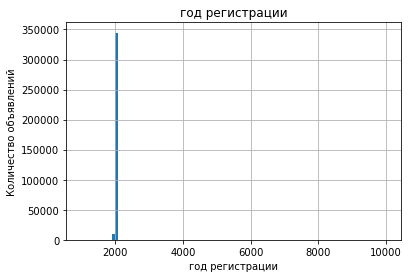

In [28]:
df_fixed.registration_year.hist(bins=100);
plt.title('год регистрации')
plt.xlabel('год регистрации');
plt.ylabel('Количество объявлений');

In [29]:
df[df.registration_year > 2018].count()

date_crawled          130
price                 130
vehicle_type            0
registration_year     130
gearbox                43
power                 130
model                  83
kilometer             130
registration_month    130
fuel_type              44
brand                 130
repaired               30
datecreated           130
number_of_pictures    130
postalcode            130
lastseen              130
dtype: int64

In [30]:
df_fixed = df_fixed[(df_fixed.registration_year > 1970) & (df_fixed.registration_year < 2017)]

In [31]:
df.date_crawled.unique()

array(['2016-03-24T11:52:17.000000000', '2016-03-24T10:58:45.000000000',
       '2016-03-14T12:52:21.000000000', ...,
       '2016-03-21T09:50:58.000000000', '2016-03-14T17:48:27.000000000',
       '2016-03-19T18:57:12.000000000'], dtype='datetime64[ns]')

In [32]:
df.date_crawled.apply(lambda x: x.year).unique()

array([2016], dtype=int64)

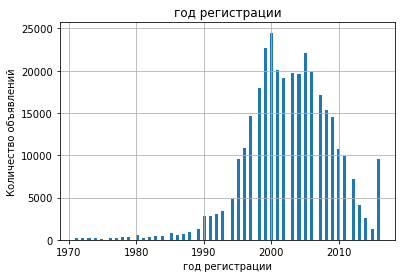

In [33]:
df_fixed.registration_year.hist(bins=100);
plt.title('год регистрации')
plt.xlabel('год регистрации');
plt.ylabel('Количество объявлений');

In [34]:
df_fixed.price.value_counts(ascending = True)

10985       1
17047       1
11488       1
7893        1
915         1
         ... 
1200     4322
1000     4350
1500     5079
500      5449
0        9809
Name: price, Length: 3687, dtype: int64

In [35]:
df_fixed.price.describe()

count    338164.000000
mean       4461.486211
std        4535.426539
min           0.000000
25%        1099.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [36]:
df_fixed = df_fixed[df_fixed.price > 499]

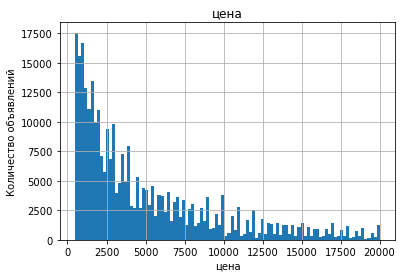

In [37]:
df_fixed.price.hist(bins=100);
plt.title('цена');
plt.xlabel('цена');
plt.ylabel('Количество объявлений');

In [38]:
df_fixed.power.value_counts(ascending = True)

1548        1
612         1
6018        1
6006        1
2461        1
        ...  
60      12042
140     12212
150     13429
75      19636
0       25046
Name: power, Length: 647, dtype: int64

In [39]:
df_fixed.power.describe()

count    303981.000000
mean        116.180274
std         185.130542
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64

In [40]:
df_fixed.power.describe()

count    303981.000000
mean        116.180274
std         185.130542
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64

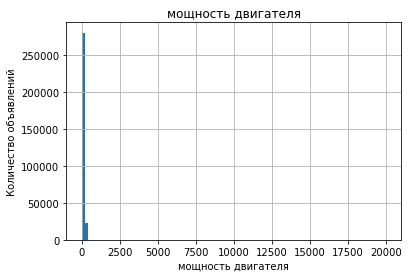

In [41]:
df_fixed.power.hist(bins=100);
plt.title('мощность двигателя');
plt.xlabel('мощность двигателя');
plt.ylabel('Количество объявлений');

In [42]:
df_fixed = df_fixed[(df_fixed.power > 35) & (df_fixed.power < 250)]

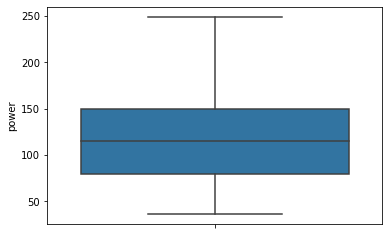

In [43]:
sns.boxplot(data = df_fixed, y='power');

## 2.3.4 Подготовка данных для обучения

Очевидно что от даты публикации и данных пользователя цена не зависит

In [44]:
df_fixed.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'datecreated', 'number_of_pictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [45]:
df_fixed = df_fixed.drop(columns = ['date_crawled', 'datecreated', 'postalcode', 'lastseen']) 

In [46]:
df_fixed.number_of_pictures.value_counts()

0    270524
Name: number_of_pictures, dtype: int64

Столбец с количеством фото явно битый 

In [47]:
df_fixed = df_fixed.drop(columns = 'number_of_pictures') 

In [48]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270524 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               270524 non-null  int64 
 1   vehicle_type        262316 non-null  object
 2   registration_year   270524 non-null  int64 
 3   gearbox             266176 non-null  object
 4   power               270524 non-null  int64 
 5   model               261645 non-null  object
 6   kilometer           270524 non-null  int64 
 7   registration_month  270524 non-null  int64 
 8   fuel_type           258224 non-null  object
 9   brand               270524 non-null  object
 10  repaired            270524 non-null  object
dtypes: int64(5), object(6)
memory usage: 24.8+ MB


In [49]:
df_fixed.corr().style.background_gradient(cmap='coolwarm')

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.544253,0.473645,-0.413667,0.052229
registration_year,0.544253,1.000000,0.122248,-0.357096,0.033703
power,0.473645,0.122248,1.000000,0.123432,0.028159
kilometer,-0.413667,-0.357096,0.123432,1.000000,-0.013625
registration_month,0.052229,0.033703,0.028159,-0.013625,1.000000


In [50]:
df_fixed = df_fixed.reset_index(drop = True)

Проверим на дубликаты 

In [51]:
df_fixed.duplicated().sum()

24693

In [52]:
df_fixed = df_fixed.drop_duplicates()

In [53]:
df_fixed.duplicated().sum()

0

In [54]:
df_fixed = df_fixed.drop(columns= 'registration_month')

Столбец repaired явно булевый 

**Вывод**:

В ходе данного этапа был загружен датасет и обработан датасет, импортированы необходимые библиотеки.
Было выявлено:

1. Пропуски в признаках VehicleType, Gearbox, Model, FuelType, Repaired  
2. 4 явных дубликата
3. Название столбцов не snake_case
4. Есть ошибочные данные и выбросы в признаках года регистрации, мощности двигателя и целевом признаке
5. Есть неявные дубликаты в признаке FuelType
6. Определено, что личные данные владельца, а так же месяц регистрации автомобиля никак не влияют на цену
7. Датасет был выгружен в 2016 году

В ходе выполнения этапа:

1. Удалены вяные дубликаты
2. Обработаны пропуски в столбце FuelType
3. Названия стобцов преведены к snake case
4. Удалены выбросы в признаках года регистрации, мощности двигателя и целевом признаке
5. Удалены признаки, которые не влияют на целевой признак

Можно переходить к подготовке выборок и обучению модели

# 3 Построение модели

## 3.1. Подготовка модели

Присутствуют категориальные переменные. Используем OrdinalEncoder

In [57]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245831 entries, 0 to 270523
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              245831 non-null  int64 
 1   vehicle_type       237889 non-null  object
 2   registration_year  245831 non-null  int64 
 3   gearbox            241636 non-null  object
 4   power              245831 non-null  int64 
 5   model              237304 non-null  object
 6   kilometer          245831 non-null  int64 
 7   fuel_type          233847 non-null  object
 8   brand              245831 non-null  object
 9   repaired           245831 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.6+ MB


In [58]:
df_fixed.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [59]:
df_fixed.isna().sum()

price                    0
vehicle_type          7942
registration_year        0
gearbox               4195
power                    0
model                 8527
kilometer                0
fuel_type            11984
brand                    0
repaired                 0
dtype: int64

In [60]:
df_feartures = df_fixed.drop(columns='price')
df_target = df_fixed['price']

**Определяем выборки**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_feartures, df_target, test_size=0.2, random_state=0)

**Готовим препроцессор с OHE**

In [62]:
numeric_features = ["power"]

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["vehicle_type", "gearbox", "model", "fuel_type", "brand", "repaired", "kilometer", "registration_year"]
categorical_transformer = Pipeline(
    steps=[("imput" ,SimpleImputer(strategy='constant', fill_value='unknown')),
        ("encoder", OneHotEncoder(drop='first'))      
    ]
)

In [63]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [64]:
X_train_ohe = preprocessor1.fit_transform(X_train)

**Строим модель**

In [65]:
model = LinearRegression()

In [66]:
params = {}
gs = GridSearchCV(model, params, cv=5, return_train_score=True, scoring='neg_mean_squared_error')

In [67]:
gs.fit(X_train_ohe, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
abs(gs.best_score_)**0.5

1955.6594512748989

In [69]:
start = time()
model.fit(X_train_ohe, y_train)
end = time()
model_time = (end-start)
print(f'время обучения: {model_time}, c')

время обучения: 16.807413816452026, c


In [70]:
start = time()
model.predict(X_train_ohe)
end = time()
model_time = (end-start)
print(f'время предсказания: {model_time}, c')

время предсказания: 0.028977155685424805, c


Теперь попробуем бустинг 

**Готовим препроцессор с Ordinal Encoder для бустинга**

In [85]:
categorical_features = ["vehicle_type", "gearbox", "model", "fuel_type", "brand", "repaired", "kilometer", "registration_year"]
categorical_transformer = Pipeline(
    steps=[("imput" ,SimpleImputer(strategy='constant', fill_value='unknown')),
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan))      
    ]
)

In [86]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [87]:
X_train_ordinal = preprocessor2.fit_transform(X_train)

**Строим модель**

In [88]:
model = LGBMRegressor(random_state=42)

In [89]:
params = {'n_estimators': [50, 80, 100], 'num_leaves': [5, 15, 30]}
gs = GridSearchCV(model, params, cv=5, return_train_score=True, scoring='neg_mean_squared_error')

In [90]:
gs.fit(X_train_ordinal, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'n_estimators': [50, 80, 100],
                         'num_leaves': [5, 15, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [91]:
abs(gs.best_score_)**0.5

1586.417224717673

In [92]:
gs.best_params_

{'n_estimators': 100, 'num_leaves': 30}

In [93]:
model =  LGBMRegressor(random_state=42, n_estimators = 100, num_leaves = 30)

In [94]:
start = time()
model.fit(X_train_ordinal, y_train)
end = time()
model_time = (end-start)
print(f'время обучения: {model_time}, c')

время обучения: 5.40294075012207, c


In [95]:
start = time()
model.predict(X_train_ordinal)
end = time()
model_time = (end-start)
print(f'время предсказания: {model_time}, c')

время предсказания: 1.7719941139221191, c


Градиентный бустинг медленее и требует больше вычислительных ресурсов, но обладает гораздо меньшим RMSE

Линейная регрессия без оптимизации параметров

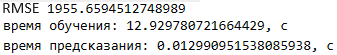!

Бустинг с оптимизацией параметров 

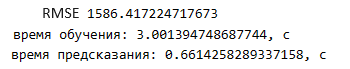

**Вывод:** 

Бустинг работает медленнее, однако обеспечивает лучшую RMSE

## 3.2. Тестирование модели

In [96]:
X_test_ohe = preprocessor1.transform(X_test)
X_test_ordinal = preprocessor2.transform(X_test)

In [97]:
start = time()
model.predict(X_test_ordinal)
end = time()
model_time = (end-start)
print(f'время предсказания: {model_time}, c')

время предсказания: 0.4411337375640869, c


In [98]:
print(f'RMSE: {mean_squared_error(y_test, model.predict(X_test_ordinal))**0.5}')

RMSE: 1591.122357297115


Сравним с константной моделью

In [110]:
model = DummyRegressor(strategy= 'median')

In [111]:
start = time()
model.fit(X_train_ohe, y_train)
end = time()
model_time = (end-start)
print(f'время обучения: {model_time}, c')

время обучения: 0.005995750427246094, c


In [112]:
start = time()
model.predict(X_test_ohe)
end = time()
model_time = (end-start)
print(f'время предсказания: {model_time}, c')

время предсказания: 0.0009963512420654297, c


In [113]:
print(f'RMSE: {mean_squared_error(y_test, model.predict(X_test_ohe))**0.5}')

RMSE: 4777.709583941769


# 4 Вывод

## 4.1 Постановка задачи

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Требуестя построить модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей. Для оценки использовать RMSE. Значение метрики RMSE должно быть меньше 2500.

## 4.2 Ход решения

В ходе решения задачи был загружен и обработан датасет сервиса по продаже автомобилей.

В ходе анализа данных было выявлено следующее:

1. Пропуски в признаках VehicleType, Gearbox, Model, FuelType, Repaired  
2. 4 явных дубликата
3. Все "временные" признаки имеют не DateTime тип переменной. 
4. Название столбцов не snake_case
5. Столбец с количеством фото содержит нули

В ходе предобработки данных были заполнены пропуски в столбце типа топлива по модели и мощности, удалены явные дубликаты и выбросы.

В ходе подготовки выборок для построения моделей были отброшены столбцы, с персональными данными которые не влиют на цену автомобиля, заполнены оставшиеся значения NAN с помощью SimpleImputer, нормированы количественные переменные c помощью StandardScaler, кодированы категориальные переменные с помощью OHE

По выборкам были построены модели 

## 4.3 Выводы

Обе построенные модели удовлетворяют условию RMSE <2500
Конечно модель градиентного бустинга имеет намного меньшую ошибку и требует больше машинного времени и вычислительных ресурсов
Результаты ниже

Линейная регрессия с градиентным бустингом 

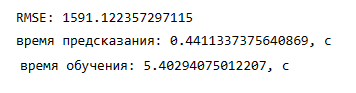

Константная модель

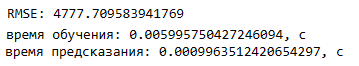